# Table of Contents
 <p>

In [115]:
from __future__ import print_function
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
import numpy as np

%matplotlib inline

In [131]:
n_samples = 300
np.random.seed(0)

blobs = datasets.make_blobs(n_samples=n_samples, random_state=8, centers=2)
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
# no_structure = np.random.rand(n_samples, 2), None

datasets_list = [noisy_circles, noisy_moons, blobs]
datasets_name = ["noisy_circles", "noisy_moons", "blobs"]

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

plt.figure(figsize=(len(datasets_list) * 2 + 6, 4))
#plt.subplots_adjust(left=.00, right=.98, bottom=.001, top=.96, wspace=.05,
#                    hspace=.01)


plot_num = 1
for i_dataset, (dataset, dataset_name) in enumerate(zip(datasets_list, datasets_name)):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    plt.subplot(1, len(datasets_list), plot_num)
    plt.title(datasets_name[i_dataset], size=18)
    plt.scatter(X[:, 0], X[:, 1], color=colors[y].tolist(), s=10)
    plot_num += 1
plt.savefig("data.png")

TypeError: 'tuple' object does not support item assignment

In [117]:
import json

from embedded_jubatus import Clustering
from jubatus.clustering.types import WeightedDatum
from jubatus.clustering.types import WeightedIndex
from jubatus.clustering.types import IndexedPoint
from jubatus.common import Datum


CONFIG = {
    'method': 'kmeans',
    'parameter': {
        'k' : 2,
        'seed' : 0,
    },
    'compressor_parameter': {
        'bucket_size': 2,
    },
    'compressor_method' : 'simple',
    'converter': {
        'num_filter_types': {},
        'num_filter_rules': [],
        'string_filter_types': {},
        'string_filter_rules': [],
        'num_types': {},
        'num_rules': [
            {'key': '*', 'type': 'num'}
        ],
        'string_types': {},
        'string_rules': [
            {'key': '*', 'type': 'space',
             'sample_weight': 'bin', 'global_weight': 'bin'}
        ]
    },
}

client = Clustering(CONFIG)

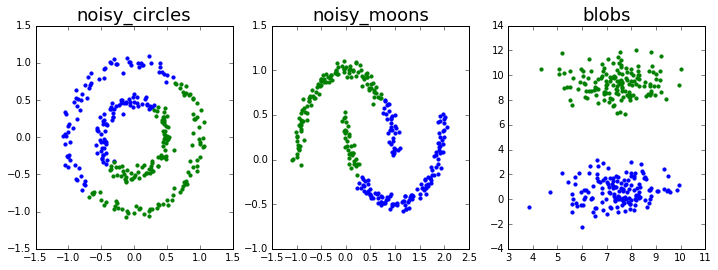

In [110]:
plot_num = 1
plt.figure(figsize=(len(datasets_list) * 2 + 6, 4))
for i_dataset, (dataset, dataset_name) in enumerate(zip(datasets_list, datasets_name)):
    plt.subplot(1, len(datasets_list), plot_num)

    plt.title(datasets_name[i_dataset], size=18)
    
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    i = 0
    client.clear()
    for row in X:
        client.push([IndexedPoint(str(i), Datum({'x' : row[0], 'y' : row[1]}))])
        i += 1
#    print("{0} push done.".format(datasets_name[i_dataset]))
    
    clusters = client.get_core_members_light()
        
    y = 0
    for cluster in clusters:
        for weighted_index in cluster:           
            plt.scatter(X[int(weighted_index.id), 0], X[int(weighted_index.id), 1], color=colors[y].tolist(), s=10)
        y += 1
    plot_num += 1
plt.savefig("kmeans.png")

In [ ]:
CONFIG['method'] = 'gmm'
client = Clustering(CONFIG)

In [ ]:
plot_num = 1
plt.figure(figsize=(len(datasets_list) * 2 + 6, 4))
for i_dataset, (dataset, dataset_name) in enumerate(zip(datasets_list, datasets_name)):
    plt.subplot(1, len(datasets_list), plot_num)

    plt.title(datasets_name[i_dataset], size=18)
    
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    i = 0
    client.clear()
    for row in X:
        client.push([IndexedPoint(str(i), Datum({'x' : row[0], 'y' : row[1]}))])
        i += 1
    print("{0} push done.".format(datasets_name[i_dataset]))
    
    clusters = client.get_core_members_light()
        
    y = 0
    for cluster in clusters:
        for weighted_index in cluster:           
            plt.scatter(X[int(weighted_index.id), 0], X[int(weighted_index.id), 1], color=colors[y].tolist(), s=10)
        y += 1
    plot_num += 1
plt.savefig("gmm.png")

In [139]:
CONFIG['method'] = 'dbscan'
if 'k' in CONFIG['parameter']:
    del(CONFIG['parameter']['k'])
if 'seed' in CONFIG['parameter']:
    del(CONFIG['parameter']['seed'])
CONFIG['parameter']['eps'] = 0.3
CONFIG['parameter']['min_core_point'] = 2
print(CONFIG)
client = Clustering(CONFIG)

{'compressor_method': 'simple', 'compressor_parameter': {'bucket_size': 2}, 'parameter': {'eps': 0.3, 'min_core_point': 2}, 'method': 'dbscan', 'converter': {'string_filter_types': {}, 'string_rules': [{'sample_weight': 'bin', 'type': 'space', 'global_weight': 'bin', 'key': '*'}], 'num_rules': [{'type': 'num', 'key': '*'}], 'num_filter_types': {}, 'string_types': {}, 'num_filter_rules': [], 'num_types': {}, 'string_filter_rules': []}}


noisy_circles push done.
noisy_moons push done.
blobs push done.


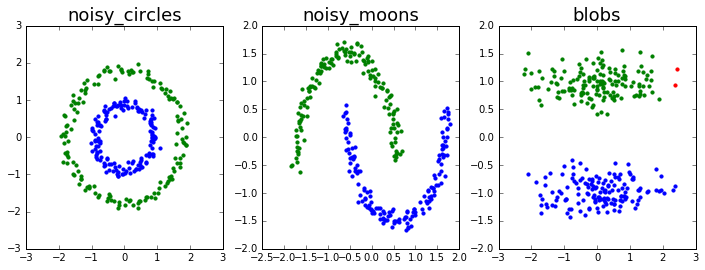

In [140]:
plot_num = 1
plt.figure(figsize=(len(datasets_list) * 2 + 6, 4))
for i_dataset, (dataset, dataset_name) in enumerate(zip(datasets_list, datasets_name)):
    plt.subplot(1, len(datasets_list), plot_num)

    plt.title(datasets_name[i_dataset], size=18)
    
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    i = 0
    client.clear()
    for row in X:
        client.push([IndexedPoint(str(i), Datum({'x' : row[0], 'y' : row[1]}))])
        i += 1
    print("{0} push done.".format(datasets_name[i_dataset]))
    
    clusters = client.get_core_members_light()
        
    y = 0
    for cluster in clusters:
        for weighted_index in cluster:           
            plt.scatter(X[int(weighted_index.id), 0], X[int(weighted_index.id), 1], color=colors[y].tolist(), s=10)
        y += 1
    plot_num += 1
plt.savefig("dbscan.png")